In [5]:
# see if we add up mutations to make others in other variants if the binding affinity prediction is reasobale,,, this hsould highlight the depenance of mutations on each other....  this is a good exploration...
import pandas as pd
#! pip3 install --upgrade pandas
import numpy as np
import matplotlib.pyplot as plt
# !pip install nglview
# import xpdb  # this is the module described below
from Bio.PDB import *
#import nglview as nv
import ipywidgets
import os
from matplotlib import cm
from scipy.ndimage.filters import gaussian_filter
from matplotlib.ticker import NullFormatter
import difflib
from Bio import SeqIO
from pysam import FastaFile
from sklearn.metrics import r2_score 
from sklearn.metrics import mean_squared_error
from matplotlib.pyplot import figure
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score


In [6]:
variant_scores_path = "/mnt/ncshare/ozkilim/charge_pca_deepmut/SARS-CoV-2-RBD_DMS_variants/results/final_variant_scores/final_variant_scores.csv"

variants_names = {
    "Wuhan-Hu-1": "Wuhan-Hu-1",
    "N501Y": "Alpha", 
    "Beta": "Beta",
    "Delta": "Delta",
    "E484K": "Eta",
}

# Expression and Binding scores per variant background -- for the heatmap plots
scores_df = (
    pd.read_csv(variant_scores_path)
        .rename(columns = {"position":"site",
                           "delta_expr":"RBD expression", # rename for the selection menus 
                           "delta_bind":"ACE2 binding"    # rename for the selection menus 
                          })
        .replace({"target":variants_names})
)

wuhan = scores_df.loc[scores_df["target"] == "Wuhan-Hu-1"]

Beta = scores_df.loc[scores_df["target"] == "Beta"]
Alpha = scores_df.loc[scores_df["target"] == "Alpha"]
Delta = scores_df.loc[scores_df["target"] == "Delta"]
Eta = scores_df.loc[scores_df["target"] == "Eta"]

# get the list of one mutations needed from wuhan to omicron...
# A363L --> use standard wuhan or does not matter..
wuhan_baseline =  "NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKST"

def get_muts_list(wuhan_baseline,variant):
    """Get the differences between two sequaneces in the form needed to retireve files"""
    mut_list = []
    start = 331
    for i in range(len(wuhan_baseline)):
        if wuhan_baseline[i] != variant[i]:
            mut_name = str(wuhan_baseline[i]) + str(i+start) + str(variant[i])
            mut_list.append(mut_name)
    return mut_list    

def model(mut_list):
    """Intakes the list of point mutations from wuhan to a target variant.
    Outputs the sum/product of single binding affinity contributions.
    This is so we can compare htis to the multipl emutated Kd and
    evaluate a baseline/ see how independant the individual mutations are."""
    kd_list = []
    for mut in mut_list:
        single_kd = wuhan.loc[wuhan["mutation"]== mut]["RBD expression"].values
        kd_list.append(single_kd)
    
    model_output = np.sum(np.array(kd_list)) #product or sum?
    
    return model_output


def lin_reg(predictions,targets):   
        
    X = np.array(predictions).reshape(-1, 1)
    Y = np.array(targets)
    test_size = int(np.round(len(X)*0.2)) #20% test size
    # Split the data into training/testing sets
    X_train = X[:-test_size]
    X_test = X[-test_size:]
    # Split the targets into training/testing sets
    y_train = Y[:-test_size]
    y_test = Y[-test_size:]
    # Create linear regression object
    regr = linear_model.LinearRegression()
    # Train the model using the training sets
    regr.fit(X_train, y_train)
    # Make predictions using the testing set
    y_pred = regr.predict(X_test)
    # The coefficients
    print("Coefficients: \n", regr.coef_)
    # The mean squared error
    print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
    # The coefficient of determination: 1 is perfect prediction
    print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))

    return mean_squared_error(y_test, y_pred), r2_score(y_test, y_pred)




Coefficients: 
 [1.06101807]
Mean squared error: 0.08
Coefficient of determination: 0.93
Coefficients: 
 [1.16622735]
Mean squared error: 0.14
Coefficient of determination: 0.91
Coefficients: 
 [1.05209516]
Mean squared error: 0.09
Coefficient of determination: 0.92
Coefficients: 
 [0.96299977]
Mean squared error: 0.07
Coefficient of determination: 0.93


Text(0.5, 0.98, 'Summation of Wuhan single mutations for Expression prediction of multiple mutants')

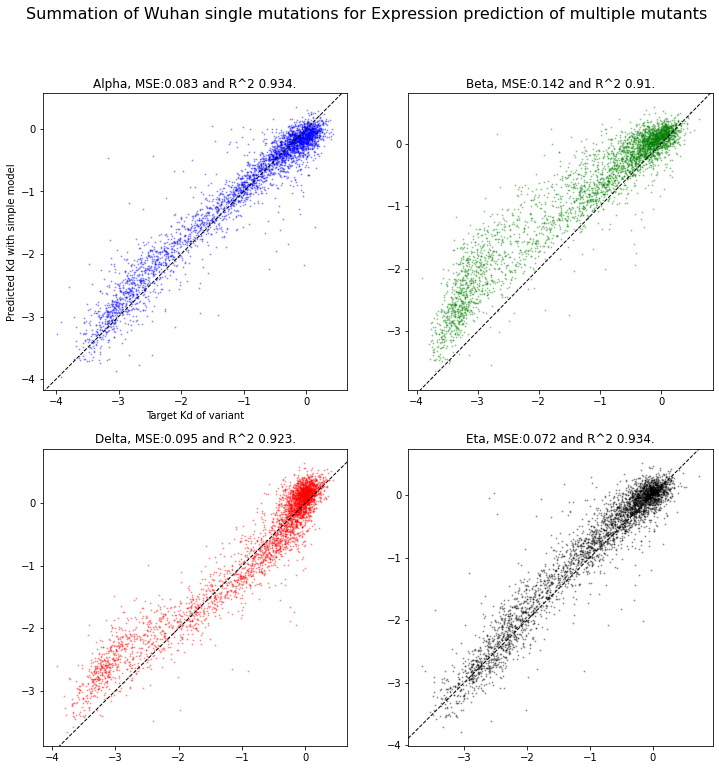

In [7]:
fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(12, 12))

alpha_folder = "/mnt/ncshare/ozkilim/charge_pca_deepmut/Fasta_files_RBD/Alpha_RBD"
targets = []
predictions = []

for filename in os.listdir(alpha_folder):
    try:
        input_file = os.path.join(alpha_folder, filename)
        target_mut = input_file[-11:-6] # get mut from fasta file name.

        with open(input_file) as handle:
            for record in SeqIO.parse(handle, "fasta"):
                variant = record.seq

        target_kd = Alpha.loc[Alpha["mutation"]==target_mut]["RBD expression"].values[0]
        mut_list = get_muts_list(wuhan_baseline,variant)
        prediction = model(mut_list)
        if not np.isnan(prediction) and not np.isnan(target_kd):
            targets.append(target_kd)
            predictions.append(prediction)
    except:
        pass
    
MSE_a, R_a = lin_reg(predictions,targets)

# fig_alpha = figure(figsize=(8, 8))
ax1.scatter(np.array(targets),np.array(predictions),s=1,alpha=0.3,c="b")
xpoints = ypoints = ax1.get_xlim()
ax1.plot(xpoints, ypoints, linestyle='--', color='k', lw=1, scalex=False, scaley=False)
#plot line in center, and R and RMSE..
ax1.set_title("Alpha, MSE:{} and R^2 {}.".format(round(MSE_a, 3), round(R_a,3)))
ax1.set_ylabel("Predicted Kd with simple model")
ax1.set_xlabel("Target Kd of variant")


beta_folder = "/mnt/ncshare/ozkilim/charge_pca_deepmut/Fasta_files_RBD/Beta_RBD"
targets = []
predictions = []

for filename in os.listdir(beta_folder):
    try:
        input_file = os.path.join(beta_folder, filename)
        target_mut = input_file[-11:-6] # get mut from fasta file name.

        with open(input_file) as handle:
            for record in SeqIO.parse(handle, "fasta"):
                variant = record.seq

        target_kd = Beta.loc[Beta["mutation"]==target_mut]["RBD expression"].values[0]
        mut_list = get_muts_list(wuhan_baseline,variant)

        prediction = model(mut_list)
        if not np.isnan(prediction) and not np.isnan(target_kd):
            targets.append(target_kd)
            predictions.append(prediction)
    except:
        pass
    
MSE_b, R_b = lin_reg(predictions,targets)

ax2.scatter(np.array(targets),np.array(predictions),s=1,alpha=0.3,c="g")
xpoints = ypoints = ax2.get_xlim()
ax2.plot(xpoints, ypoints, linestyle='--', color='k', lw=1, scalex=False, scaley=False)
ax2.set_title("Beta, MSE:{} and R^2 {}.".format(round(MSE_b, 3), round(R_b,3)))


delta_folder = "/mnt/ncshare/ozkilim/charge_pca_deepmut/Fasta_files_RBD/Delta_RBD"
targets = []
predictions = []

for filename in os.listdir(delta_folder):
    try:
        input_file = os.path.join(delta_folder, filename)
        target_mut = input_file[-11:-6] # get mut from fasta file name.

        with open(input_file) as handle:
            for record in SeqIO.parse(handle, "fasta"):
                variant = record.seq

        target_kd = Delta.loc[Delta["mutation"]==target_mut]["RBD expression"].values[0]
        mut_list = get_muts_list(wuhan_baseline,variant)

        prediction = model(mut_list)
        if not np.isnan(prediction) and not np.isnan(target_kd):
            targets.append(target_kd)
            predictions.append(prediction)
    except:
        pass
    
MSE_d, R_d = lin_reg(predictions,targets)

# fig_delta = figure(figsize=(8, 8))
ax3.scatter(np.array(targets),np.array(predictions),s=1,alpha=0.3,c="r")
xpoints = ypoints = ax3.get_xlim()
ax3.plot(xpoints, ypoints, linestyle='--', color='k', lw=1, scalex=False, scaley=False)
#plot line in center, and R and RMSE..
ax3.set_title("Delta, MSE:{} and R^2 {}.".format(round(MSE_d, 3), round(R_d,3)))


eta_folder = "/mnt/ncshare/ozkilim/charge_pca_deepmut/Fasta_files_RBD/Eta_RBD"
targets = []
predictions = []

for filename in os.listdir(eta_folder):
    try:
        input_file = os.path.join(eta_folder, filename)
        target_mut = input_file[-11:-6] # get mut from fasta file name.

        with open(input_file) as handle:
            for record in SeqIO.parse(handle, "fasta"):
                variant = record.seq

        target_kd = Eta.loc[Eta["mutation"]==target_mut]["RBD expression"].values[0]
        mut_list = get_muts_list(wuhan_baseline,variant)

        prediction = model(mut_list)
        if not np.isnan(prediction) and not np.isnan(target_kd):
            targets.append(target_kd)
            predictions.append(prediction)
    except:
        pass
    
MSE_e, R_e = lin_reg(predictions,targets)

# fig_eta = figure(figsize=(8, 8))
ax4.scatter(np.array(targets),np.array(predictions),s=1,alpha=0.3,c="black")
xpoints = ypoints = ax4.get_xlim()
ax4.plot(xpoints, ypoints, linestyle='--', color='k', lw=1, scalex=False, scaley=False)
#plot line in center, and R and RMSE..
ax4.set_title("Eta, MSE:{} and R^2 {}.".format(round(MSE_e, 3), round(R_e,3)))

fig.suptitle('Summation of Wuhan single mutations for Expression prediction of multiple mutants', fontsize=16)


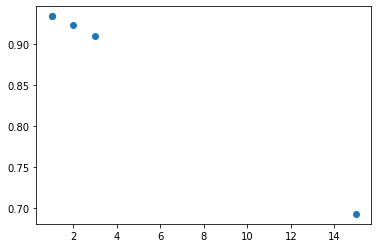

In [8]:
MSE_a,R_a

R_OBA1 = 0.693
# number of muts list?..
MSEs = [MSE_a,MSE_b,MSE_d,MSE_e]
Rs =[R_a,R_b,R_d,R_e,R_OBA1]
dists = [1,3,2,1,15] 

# plt.scatter(dists,MSEs)
# plt.show()

plt.scatter(dists,Rs)
plt.show()

# for some rerason the model does not work for alpha s expected?... why?

# seems that alpha is an anomoly?...
# understand this..?

Coefficients: 
 [0.42564433]
Mean squared error: 0.09
Coefficient of determination: 0.69


Text(0.5, 1.0, 'Omicron B1A, MSE:0.089 and R^2 0.693.')

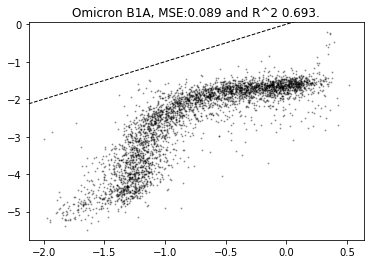

In [9]:
variant_scores_path = "/mnt/ncshare/ozkilim/charge_pca_deepmut/SARS-CoV-2-RBD_DMS_Omicron/results/final_variant_scores/final_variant_scores.csv"

variants_names = {
    "Omicron_BA1":"Omicron_BA1",
    "Omicron_BA2":"Omicron_BA2",
    "Wuhan-Hu-1": "Wuhan-Hu-1",
    "N501Y": "Alpha", 
    "Beta": "Beta",
    "Delta": "Delta",
    "E484K": "Eta",
}

# Expression and Binding scores per variant background -- for the heatmap plots
scores_df = (
    pd.read_csv(variant_scores_path)
        .rename(columns = {"position":"site",
                           "delta_expr":"RBD expression", # rename for the selection menus 
                           "delta_bind":"ACE2 binding"    # rename for the selection menus 
                          })
        .replace({"target":variants_names})
)

omicronBA1 = scores_df.loc[scores_df["target"] == "Omicron_BA1"]
omicronBA2 = scores_df.loc[scores_df["target"] == "Omicron_BA2"]

omicron_folder = "Fasta_files_RBD/Omicron_RBD"
targets = []
predictions = []

# here we can find what trype of omicron we actually generated!

for filename in os.listdir(omicron_folder):
    try:
        input_file = os.path.join(omicron_folder, filename)
        target_mut = input_file[-11:-6] # get mut from fasta file name.

        with open(input_file) as handle:
            for record in SeqIO.parse(handle, "fasta"):
                variant = record.seq

        target_kd = omicronBA1.loc[omicronBA1["mutation"]==target_mut]["RBD expression"].values[0]
        mut_list = get_muts_list(wuhan_baseline,variant)

        prediction = model(mut_list)
        if not np.isnan(prediction) and not np.isnan(target_kd):
            targets.append(target_kd)
            predictions.append(prediction)
    except:
        pass
    
MSE_e, R_e = lin_reg(predictions,targets)

# fig_eta = figure(figsize=(8, 8))
plt.scatter(np.array(targets),np.array(predictions),s=1,alpha=0.3,c="black")
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=1, scalex=False, scaley=False)
#plot line in center, and R and RMSE..
plt.title("Omicron B1A, MSE:{} and R^2 {}.".format(round(MSE_e, 3), round(R_e,3)))